
## Cria a Tabela dos Preços 

In [0]:
# File location and type
file_location = "/FileStore/tables/price_data-9.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ";"

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

In [0]:
# Create a view or table

temp_table_name = "price_data"

df.createOrReplaceTempView(temp_table_name)

In [0]:
%sql

/* Query the created temp table in a SQL cell */

select * from `price_data`

Open Time,Open,High,Low,Close,Volume
11/06/2024 00:00:00,"69558,8",69600,"69543,4","69599,4","579,761"
11/06/2024 00:05:00,"69599,4","69599,4","69519,5","69554,4","270,477"
11/06/2024 00:10:00,"69554,5",69600,"69554,5","69561,7","106,359"
11/06/2024 00:15:00,"69561,6","69597,6",69554,"69591,8","100,241"
11/06/2024 00:20:00,"69591,8","69597,7","69557,8","69575,7","97,986"
11/06/2024 00:25:00,"69575,8","69594,2",69520,"69520,1","144,91"
11/06/2024 00:30:00,69520,"69576,8",69520,"69557,5","336,114"
11/06/2024 00:35:00,"69557,5","69558,5","69458,8","69479,2","345,393"
11/06/2024 00:40:00,"69479,2",69493,"69454,1","69472,9","336,876"
11/06/2024 00:45:00,"69472,9",69500,"69456,2","69491,6","172,487"


In [0]:
# With this registered as a temp view, it will only be available to this particular notebook. If you'd like other users to be able to query this table, you can also create a table from the DataFrame.
# Once saved, this table will persist across cluster restarts as well as allow various users across different notebooks to query this data.
# To do so, choose your table name and uncomment the bottom line.

permanent_table_name = "price_data"

df.write.format("parquet").saveAsTable(permanent_table_name)

## Cria a Tabela do Open Interest

In [0]:
# File location and type
file_location = "/FileStore/tables/open_interest-9.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ";"

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

In [0]:
# Create a view or table

temp_table_name = "open_interest"

df.createOrReplaceTempView(temp_table_name)

In [0]:
%sql

/* Query the created temp table in a SQL cell */

select * from `open_interest`

symbol,sumOpenInterest,sumOpenInterestValue,Datetime
BTCUSDT,"85572,685",5952333281,11/06/2024 00:00:00
BTCUSDT,"85538,914",5953457091,11/06/2024 00:05:00
BTCUSDT,"85615,719",5954958527,11/06/2024 00:10:00
BTCUSDT,"85586,589",5953545143,11/06/2024 00:15:00
BTCUSDT,"85577,169",5955460672,11/06/2024 00:20:00
BTCUSDT,"85571,311",5953657883,11/06/2024 00:25:00
BTCUSDT,"85594,72",5950553494,11/06/2024 00:30:00
BTCUSDT,"85711,535",5961880096,11/06/2024 00:35:00
BTCUSDT,"85659,378",5951360564,11/06/2024 00:40:00
BTCUSDT,"85694,516",5953249207,11/06/2024 00:45:00


In [0]:
# With this registered as a temp view, it will only be available to this particular notebook. If you'd like other users to be able to query this table, you can also create a table from the DataFrame.
# Once saved, this table will persist across cluster restarts as well as allow various users across different notebooks to query this data.
# To do so, choose your table name and uncomment the bottom line.

permanent_table_name = "open_interest"

df.write.format("parquet").saveAsTable(permanent_table_name)

## Cria a Tabela do Long/Short Ratio

In [0]:
# File location and type
file_location = "/FileStore/tables/longshort_ratio-3.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ";"

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

In [0]:
# Create a view or table

temp_table_name = "longshort_ratio"

df.createOrReplaceTempView(temp_table_name)

In [0]:
%sql

/* Query the created temp table in a SQL cell */

select * from `longshort_ratio`

symbol,Long Account,Long/Short Ratio,Short Account,Datetime
BTCUSDT,"0,5845","1,4067","0,4155",11/06/2024 00:05:00
BTCUSDT,"0,5846","1,4073","0,4154",11/06/2024 00:10:00
BTCUSDT,"0,5854","1,412","0,4146",11/06/2024 00:15:00
BTCUSDT,"0,5859","1,4149","0,4141",11/06/2024 00:20:00
BTCUSDT,"0,5862","1,4166","0,4138",11/06/2024 00:25:00
BTCUSDT,"0,5863","1,4172","0,4137",11/06/2024 00:30:00
BTCUSDT,"0,586","1,4155","0,414",11/06/2024 00:35:00
BTCUSDT,"0,5861","1,416","0,4139",11/06/2024 00:40:00
BTCUSDT,"0,5863","1,4172","0,4137",11/06/2024 00:45:00
BTCUSDT,"0,5863","1,4172","0,4137",11/06/2024 00:50:00


In [0]:
# With this registered as a temp view, it will only be available to this particular notebook. If you'd like other users to be able to query this table, you can also create a table from the DataFrame.
# Once saved, this table will persist across cluster restarts as well as allow various users across different notebooks to query this data.
# To do so, choose your table name and uncomment the bottom line.

permanent_table_name = "longshort_ratio"

df.write.format("parquet").saveAsTable(permanent_table_name)

## Realiza a leitura das tabelas criadas no DBFS

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, regexp_replace, max,min, sum
import matplotlib.pyplot as plt
import seaborn as sns

# Inicialize a SparkSession
spark = SparkSession.builder \
    .appName("Tabelas MVP") \
    .getOrCreate()

# Nome das tabelas criadas
tabela1 = "longshort_ratio"
tabela2 = "open_interest"
tabela3 = "price_data"

# Ler as tabelas usando Spark SQL
df_tabela1 = spark.table(tabela1)
df_tabela2 = spark.table(tabela2)
df_tabela3 = spark.table(tabela3)

## Realiza a junção entre as 3 tabelas e realiza o tratamento de dados

In [0]:
# Realizar a junção
df_merged = df_tabela3.join(df_tabela2, col('Open Time')==col('Datetime'),'inner')
df_merged = df_merged.join(df_tabela1, on='Datetime',how='inner')

# Remover colunas específicas do DataFrame
remover = ["Datetime","symbol","symbol","Long Account", "Short Account"]
df = df_merged.drop(*remover)

# Lista de colunas a serem convertidas
converter = ["Open", "High", "Low","Close","Volume","sumOpenInterest","Long/Short Ratio"]

# Aplicando a substituição usando regexp_replace e convertendo para DoubleType
for column in converter:
    df = df.withColumn(column, regexp_replace(col(column), ',', '.').cast(DoubleType()))


## Verificando o topo do período estudado

In [0]:
# Encontra o valor máximo no período estudado
max_valor = df.agg(max("High")).collect()[0][0]

max_valor 

Out[70]: 70028.0

## Verificando o fundo do período estudado

In [0]:
# Encontra o valor mínimo no período estudado
min_valor = df.agg(min("Low")).collect()[0][0]

min_valor

Out[71]: 58218.0

## Analisando a correlação entre 3 variáveis: Preço de Fechamento, Open Interest e Long/Short Ratio

A correlação entre 'variavel1' e 'variavel2' é: -0.9201997301237737


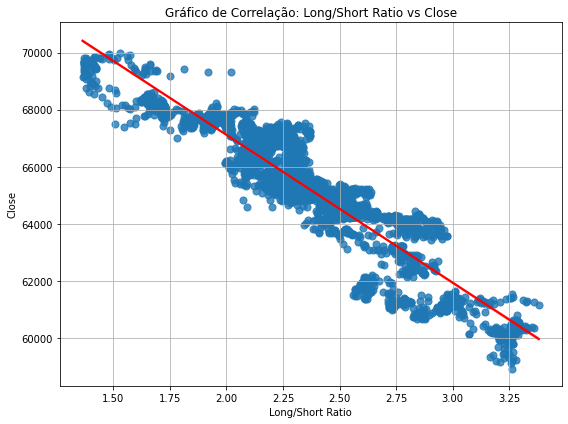

In [0]:
# 1ª Análise: Preço de Fechamento x Long/Short Ratio:

# Analisa a correlação entre o preço de fechamento e o long/short ratio
correlacao1 = df.stat.corr('Long/Short Ratio','Close')
print(f"A correlação entre 'variavel1' e 'variavel2' é: {correlacao1}")

df_pandas1 = df.select('Long/Short Ratio','Close').toPandas()

# Plotar gráfico de dispersão (scatter plot) com linha de tendência usando Seaborn
plt.figure(figsize=(8, 6))
sns.regplot(x='Long/Short Ratio', y='Close', data=df_pandas1, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Gráfico de Correlação: Long/Short Ratio vs Close')
plt.xlabel('Long/Short Ratio')
plt.ylabel('Close')
plt.grid(True)
plt.tight_layout()

plt.show()

A correlação entre 'variavel1' e 'variavel2' é: 0.6439001529722082


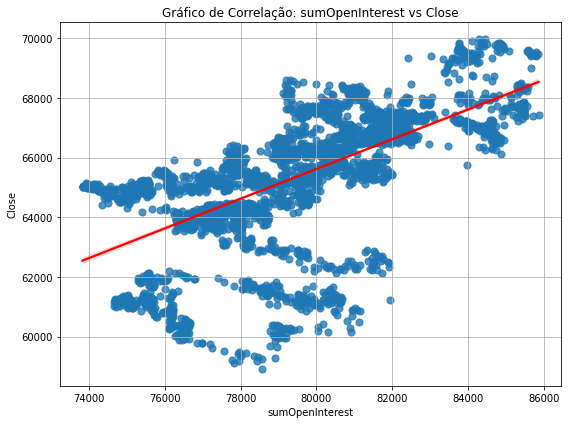

In [0]:
# 2ª Análise: Preço de Fechamento x Sum Open Interest:

# Analisa a correlação entre o preço de fechamento e a quantidade de contratos em aberto
correlacao2 = df.stat.corr('sumOpenInterest','Close')
print(f"A correlação entre 'variavel1' e 'variavel2' é: {correlacao2}")

df_pandas2 = df.select('sumOpenInterest','Close').toPandas()

# Plotar gráfico de dispersão (scatter plot) com linha de tendência usando Seaborn
plt.figure(figsize=(8, 6))
sns.regplot(x='sumOpenInterest', y='Close', data=df_pandas2, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Gráfico de Correlação: sumOpenInterest vs Close')
plt.xlabel('sumOpenInterest')
plt.ylabel('Close')
plt.grid(True)
plt.tight_layout()

plt.show()